Reconhecimento de Padrões

Lista 5: Árvores de Decisão e SVM

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import (
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [58]:
bostonbin = pd.read_csv("content/bostonbin.csv", header=None)
print(bostonbin.shape)

new_columns = {
    old_col: f"x{i}"
    for i, old_col in enumerate(bostonbin.columns[: len(bostonbin.columns)])
}
new_columns[bostonbin.columns[-1]] = "target"

bostonbin = bostonbin.rename(columns=new_columns)
bostonbin.head()

(506, 18)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,target
0,2011.0,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,1.0
1,2021.0,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,1.0
2,2022.0,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,1.0
3,2031.0,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,1.0
4,2032.0,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,1.0


In [59]:
X = bostonbin.iloc[:, 0:-1]
y = bostonbin.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)

In [60]:
class Metrics:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

        TP = 0
        FP = 0
        FN = 0

        for i in range(len(self.y_pred)):
            if self.y_true.values[i] == 1 and self.y_pred[i] == 1:
                TP += 1
            elif self.y_true.values[i] == 0 and self.y_pred[i] == 1:
                FP += 1
            elif self.y_true.values[i] == 1 and self.y_pred[i] == 0:
                FN += 1
        TN = len(self.y_true) - TP - FP - FN
        TP, FP, FN, TN

        self.TP = TP
        self.FP = FP
        self.FN = FN
        self.TN = TN

        self.accuracy = (self.TP + self.TN) / (self.TP + self.FP + self.FN + self.TN)
        self.precision = self.TP / (self.TP + self.FP)
        self.recall = self.TP / (self.TP + self.FN)
        if (self.precision + self.recall) != 0:
            self.f1_score = (
                2 * (self.precision * self.recall) / (self.precision + self.recall)
            )

        self.confusion_matrix = np.array([[self.TN, self.FN], [self.FP, self.TP]])

# Decision Tree

## Model

In [61]:
class Tree:
    def __init__(
        self,
        column=None,
        limiar=None,
        gini=None,
        left=None,
        right=None,
        is_leaf=False,
        leaf_value=None,
    ):
        # node
        self.column = column
        self.limiar = limiar
        self.gini = gini
        self.left = left
        self.right = right

        # leaf
        self.is_leaf = is_leaf
        self.leaf_value = leaf_value

In [62]:
class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3, min_leaf_samples=3, gini_stop=0):
        self.max_depth = max_depth
        self.min_leaf_samples = min_leaf_samples
        self.gini_stop = gini_stop
        self.tree = None
        self.classes_ = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.classes_ = np.unique(y)
        self.tree = self._train(X, y)
        return self

    def _train(self, X, y, current_depth=0):
        column, limiar, gini = self._gini_calculator(X, y)
        if column is None:
            leaf_value = np.bincount(y.astype(int)).argmax()
            return Tree(is_leaf=True, leaf_value=leaf_value)

        x_left = X[X[:, column] > limiar]
        y_left = y[X[:, column] > limiar]
        x_right = X[X[:, column] <= limiar]
        y_right = y[X[:, column] <= limiar]

        if (
            gini > self.gini_stop
            and current_depth < self.max_depth
            and len(x_left) >= self.min_leaf_samples
            and len(x_right) >= self.min_leaf_samples
        ):
            tree_left = self._train(x_left, y_left, current_depth + 1)
            tree_right = self._train(x_right, y_right, current_depth + 1)
            node = Tree(
                column=column,
                limiar=limiar,
                gini=gini,
                left=tree_left,
                right=tree_right,
            )
        else:
            leaf_value = np.bincount(y_left.astype(int)).argmax()
            node = Tree(is_leaf=True, leaf_value=leaf_value)

        return node

    def _gini_calculator(self, X, y):
        best_gini = float("inf")
        best_column = None
        best_limiar = None

        for column in range(X.shape[1]):
            min_val = np.min(X[:, column])
            max_val = np.max(X[:, column])
            number_uniques = np.unique(X[:, column]).size
            step_size = (max_val - min_val) / number_uniques

            limiares = [min_val + step * step_size for step in range(0, number_uniques)]
            for limiar in limiares:
                y_left = y[X[:, column] > limiar]
                y_right = y[X[:, column] <= limiar]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gini_left = 1 - np.sum(
                    (np.bincount(y_left.astype(int)) / len(y_left)) ** 2
                )
                gini_right = 1 - np.sum(
                    (np.bincount(y_right.astype(int)) / len(y_right)) ** 2
                )
                gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)

                if gini < best_gini:
                    best_gini = gini
                    best_column = column
                    best_limiar = limiar

        if best_column is None:
            return None, None, None

        return best_column, best_limiar, best_gini

    def predict(self, X):
        X = np.array(X)
        return np.array([self._traverse_tree(self.tree, row) for row in X])

    def _traverse_tree(self, node, row):
        if node.is_leaf:
            return node.leaf_value
        if row[node.column] > node.limiar:
            return self._traverse_tree(node.left, row)
        else:
            return self._traverse_tree(node.right, row)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def predict_proba(self, X):
        X = np.array(X)
        probas = np.array([self._proba_for_row(self.tree, row) for row in X])
        return probas

    def _proba_for_row(self, node, row):
        if node.is_leaf:
            probas = np.zeros(len(self.classes_))
            leaf_value = node.leaf_value
            probas[self.classes_ == leaf_value] = 1.0
            return probas

        if row[node.column] > node.limiar:
            return self._proba_for_row(node.left, row)
        else:
            return self._proba_for_row(node.right, row)

In [63]:
def plot_roc_pr(y, y_prob):
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y, y_prob)
    average_precision = average_precision_score(y, y_prob)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(
        recall,
        precision,
        color="b",
        lw=2,
        label=f"Precision-Recall curve (AP = {average_precision:.2f})",
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall")
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Tree Grid Search

In [64]:
model = DecisionTree()

param_grid = {
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_leaf_samples": [1, 2, 3, 4, 5],
}

scoring = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=10, scoring=scoring
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTree(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_leaf_samples': [1, 2, 3, 4, 5]},
             scoring=make_scorer(<lambda>, response_method='predict'))

In [65]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação:", grid_search.best_score_)

Melhores parâmetros: {'max_depth': 7, 'min_leaf_samples': 1}
Melhor pontuação de validação: 0.8334920634920634


In [ ]:
metric = Metrics(y_test, grid_search.predict(X_test))

print("acuracy", metric.accuracy)
print("precision", metric.precision)
print("recall", metric.recall)
print("f1-score", metric.f1_score)

acuracy 0.8355263157894737
precision 0.9629629629629629
recall 0.78
f1-score 0.8618784530386739


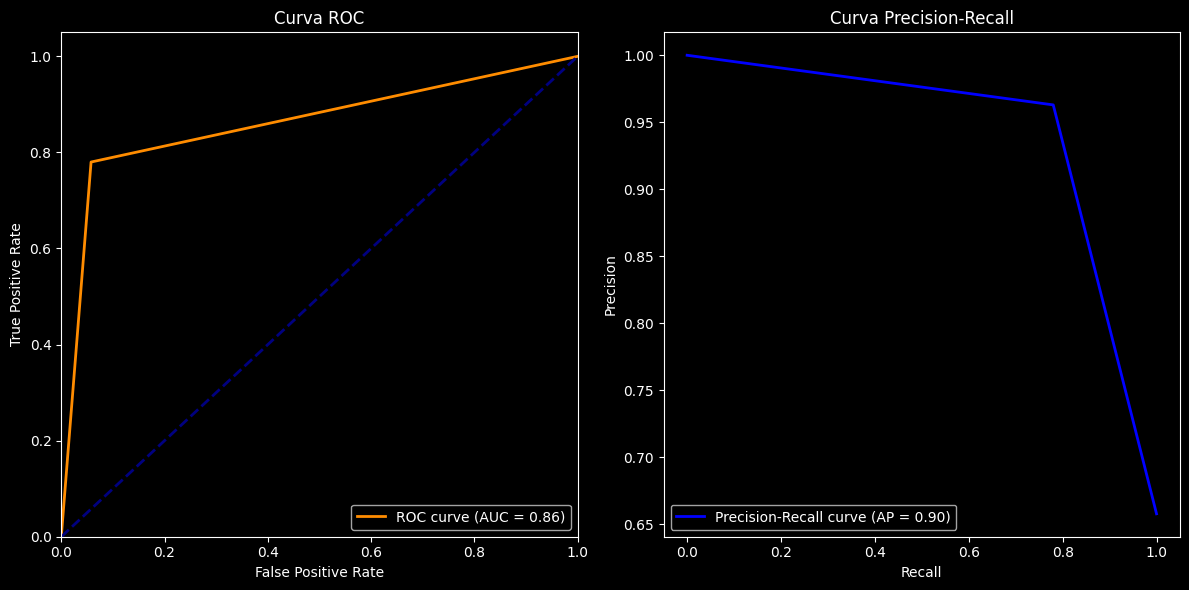

In [68]:
grid_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

plot_roc_pr(y_test, grid_proba)

## Tree Optuna

In [69]:
def objective(trial):


    max_depth = trial.suggest_int("max_depth", 1, 10)

    min_leaf_samples = trial.suggest_int("min_leaf_samples", 1, 5)

    X_train_op, X_val, y_train_op, y_val = train_test_split(
        X_train, y_train, test_size=0.3, random_state=101
    )


    model = DecisionTree(max_depth=max_depth, min_leaf_samples=min_leaf_samples)


    model.fit(X_train_op, y_train_op)

    accuracy = model.score(X_val, y_val)

    return accuracy



study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=50)


best_params = study.best_params

print(f"Best hyperparameters: {best_params}")

[I 2025-01-18 22:48:11,185] A new study created in memory with name: no-name-6bd9f78f-5df7-4a47-a72e-a48b06a319db
[I 2025-01-18 22:48:11,445] Trial 0 finished with value: 0.42990654205607476 and parameters: {'max_depth': 6, 'min_leaf_samples': 4}. Best is trial 0 with value: 0.42990654205607476.
[I 2025-01-18 22:48:11,686] Trial 1 finished with value: 0.42990654205607476 and parameters: {'max_depth': 10, 'min_leaf_samples': 5}. Best is trial 0 with value: 0.42990654205607476.
[I 2025-01-18 22:48:11,947] Trial 2 finished with value: 0.4392523364485981 and parameters: {'max_depth': 9, 'min_leaf_samples': 2}. Best is trial 2 with value: 0.4392523364485981.
[I 2025-01-18 22:48:12,171] Trial 3 finished with value: 0.42990654205607476 and parameters: {'max_depth': 6, 'min_leaf_samples': 5}. Best is trial 2 with value: 0.4392523364485981.
[I 2025-01-18 22:48:12,482] Trial 4 finished with value: 0.8411214953271028 and parameters: {'max_depth': 4, 'min_leaf_samples': 1}. Best is trial 4 with va

Best hyperparameters: {'max_depth': 3, 'min_leaf_samples': 1}


In [70]:
optuna_model = DecisionTree(**best_params)
optuna_model.fit(X_train, y_train)

DecisionTree(min_leaf_samples=1)

In [71]:
metric = Metrics(y_test, optuna_model.predict(X_test))

print("acuracy", metric.accuracy)
print("precision", metric.precision)
print("recall", metric.recall)
print("f1-score", metric.f1_score)

acuracy 0.8618421052631579
precision 0.8623853211009175
recall 0.94
f1-score 0.8995215311004784


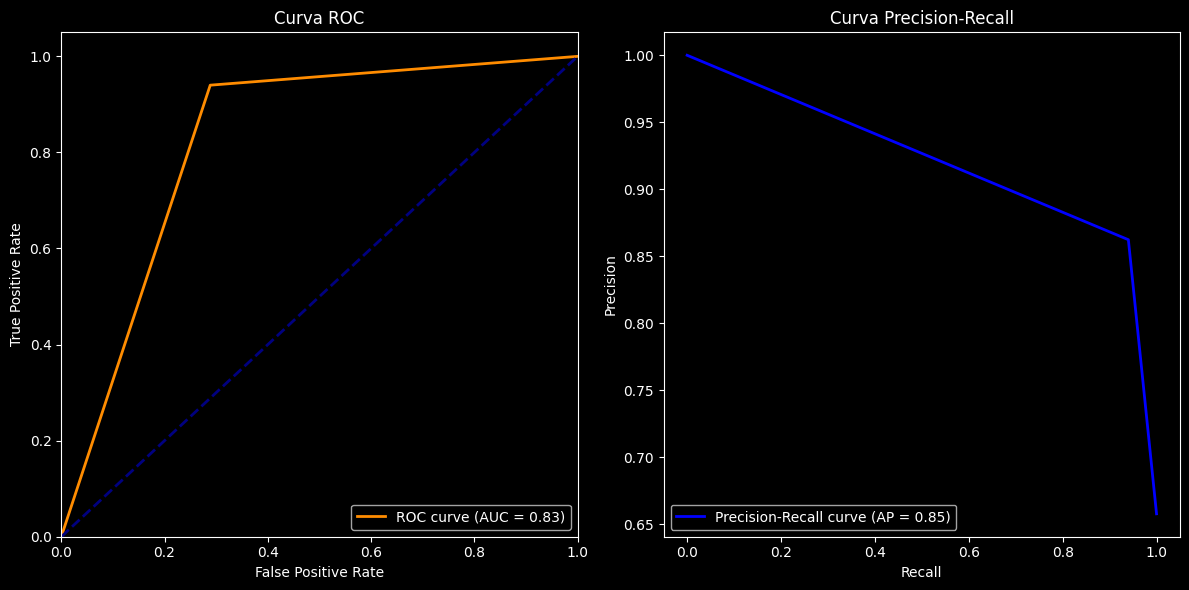

In [73]:
proba_predictions = optuna_model.predict_proba(X_test)[:, 1]
plot_roc_pr(y_test, proba_predictions)

# SVM Grid Search

In [ ]:
model = svm.SVC(kernel="rbf", probability=True)

param_grid = {
    "C": [2**x for x in range(-5, 16)],
    "gamma": [2**x for x in range(-15, 4)],
}

scoring = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=10, scoring=scoring
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64, 128, 256, 512, 1024, 2048, 4096,
                               8192, 16384, 32768],
                         'gamma': [3.0517578125e-05, 6.103515625e-05,
                                   0.0001220703125, 0.000244140625,
                                   0.00048828125, 0.0009765625, 0.001953125,
                                   0.00390625, 0.0078125, 0.015625, 0.03125,
                                   0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]},
             scoring=make_scorer(<lambda>, response_method='predict'))

In [75]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação:", grid_search.best_score_)

Melhores parâmetros: {'C': 128, 'gamma': 6.103515625e-05}
Melhor pontuação de validação: 0.8590476190476191


In [ ]:
metric = Metrics(y_test, grid_search.predict(X_test))

print("acuracy", metric.accuracy)
print("precision", metric.precision)
print("recall", metric.recall)
print("f1-score", metric.f1_score)

acuracy 0.8289473684210527
precision 0.9302325581395349
recall 0.8
f1-score 0.8602150537634408


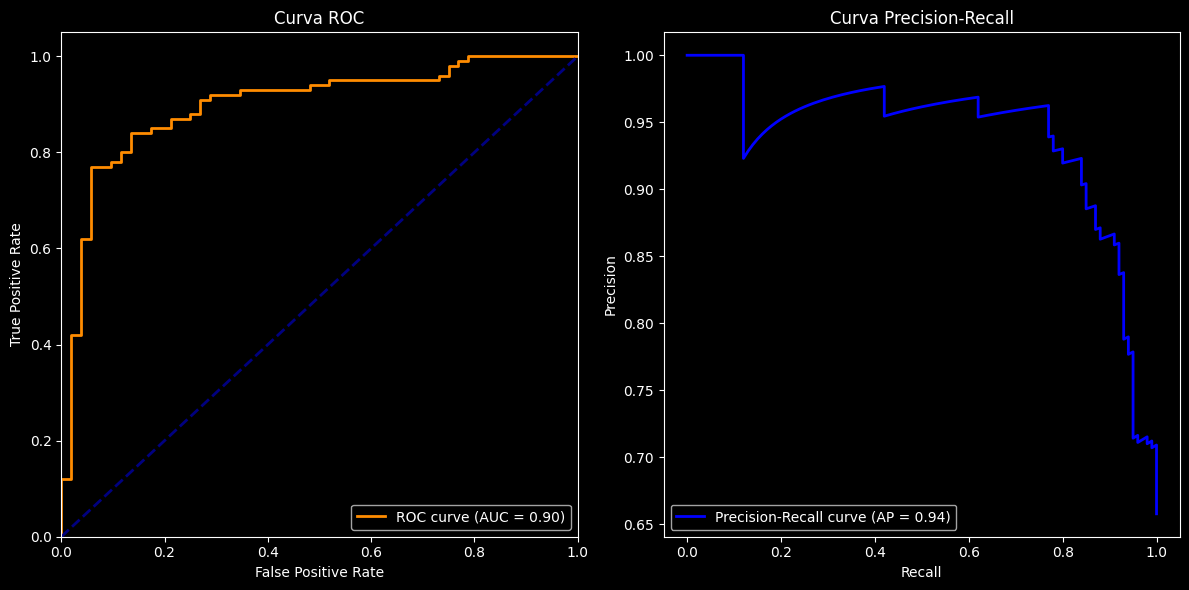

In [79]:
grid_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

plot_roc_pr(y_test, grid_proba)

## SVM Optuna

In [80]:
def objective(trial):
    C_values = [2**x for x in range(-5, 16)]
    gamma_values = [2**x for x in range(-15, 4)]

    C = trial.suggest_categorical("C", C_values)
    gamma = trial.suggest_categorical("gamma", gamma_values)

    X_train_op, X_val, y_train_op, y_val = train_test_split(
        X_train, y_train, test_size=0.3, random_state=101
    )

    model = svm.SVC(C=C, gamma=gamma)

    model.fit(X_train_op, y_train_op)
    accuracy = model.score(X_val, y_val)

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-01-18 22:52:07,427] A new study created in memory with name: no-name-4d358bd8-103d-4882-b5d7-b201fd07af19
[I 2025-01-18 22:52:07,445] Trial 0 finished with value: 0.8878504672897196 and parameters: {'C': 4, 'gamma': 6.103515625e-05}. Best is trial 0 with value: 0.8878504672897196.
[I 2025-01-18 22:52:07,459] Trial 1 finished with value: 0.7289719626168224 and parameters: {'C': 2, 'gamma': 0.015625}. Best is trial 0 with value: 0.8878504672897196.
[I 2025-01-18 22:52:07,476] Trial 2 finished with value: 0.6915887850467289 and parameters: {'C': 0.5, 'gamma': 0.0078125}. Best is trial 0 with value: 0.8878504672897196.
[I 2025-01-18 22:52:07,492] Trial 3 finished with value: 0.5233644859813084 and parameters: {'C': 0.0625, 'gamma': 0.015625}. Best is trial 0 with value: 0.8878504672897196.
[I 2025-01-18 22:52:07,509] Trial 4 finished with value: 0.8504672897196262 and parameters: {'C': 1, 'gamma': 3.0517578125e-05}. Best is trial 0 with value: 0.8878504672897196.
[I 2025-01-18 22:5

Best hyperparameters: {'C': 4, 'gamma': 6.103515625e-05}


In [81]:
optuna_model = svm.SVC(**best_params, probability=True)
optuna_model.fit(X_test, y_test)

SVC(C=4, gamma=6.103515625e-05, probability=True)

In [82]:
metric = Metrics(y, optuna_model.predict(X_test))

print("acuracy", metric.accuracy)
print("precision", metric.precision)
print("recall", metric.recall)
print("f1-score", metric.f1_score)

acuracy 0.8399209486166008
precision 0.5
recall 0.6296296296296297
f1-score 0.5573770491803278


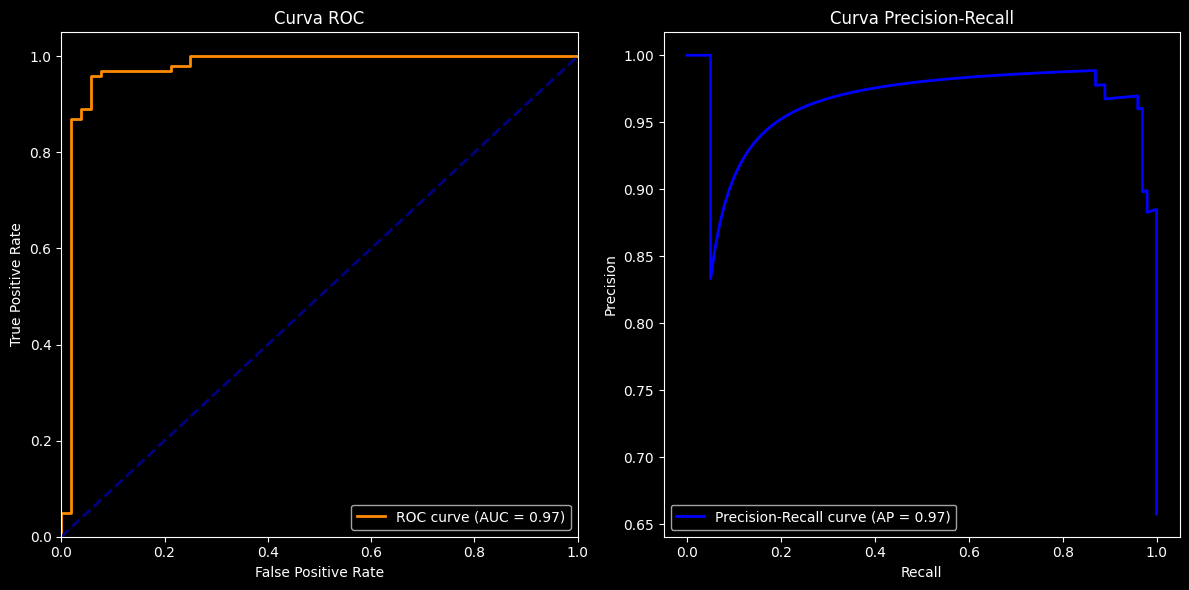

In [84]:
proba_predictions = optuna_model.predict_proba(X_test)[:, 1]
plot_roc_pr(y_test, proba_predictions)